<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#模型" data-toc-modified-id="模型-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>模型</a></span></li><li><span><a href="#加载数据" data-toc-modified-id="加载数据-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>加载数据</a></span></li><li><span><a href="#数据模型" data-toc-modified-id="数据模型-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>数据模型</a></span></li><li><span><a href="#测试图片增强" data-toc-modified-id="测试图片增强-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>测试图片增强</a></span></li><li><span><a href="#训练" data-toc-modified-id="训练-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>训练</a></span></li><li><span><a href="#预测" data-toc-modified-id="预测-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>预测</a></span></li></ul></div>

用其中一个椭圆识别数据集标注了边缘进行边缘检测训练

# 模型

In [1]:
from cnn_model import *
%matplotlib inline

# 加载数据

In [2]:
import pickle
import numpy as np

data_path = r'/home/liucc/Workspace/02_Ellipse/01_data/'
model_path = r'/home/liucc/Workspace/02_Ellipse/06_model/'
model_name = r'ellipse_general'

with open(f"{data_path}train_data_general.pdat",'rb') as f:
    datas = pickle.load(f)
    
#with open(f"{data_path}train_data.pdat",'rb') as f:
#    datas2 = pickle.load(f)

In [3]:
datas['image'][0].shape,datas['edge'][0].shape

((256, 256), (256, 256))

In [4]:
#datas2['image'][0].shape,datas2['edge'][0].shape

In [5]:
import torch 
from skimage import filters
import pickle

#xs = np.stack([np.expand_dims(filters.scharr(im['image']), 0) for im in datas],axis=0)
#xs = np.stack([np.expand_dims(im, 0) for im in datas['image']],axis=0)
#ys = np.stack([np.expand_dims(im, 0) for im in datas['edge']],axis=0)

xs = np.array(datas['image'])
ys = np.array(datas['edge'])


In [6]:
len(xs),len(ys)

(1317, 1317)

In [7]:
xs.shape,ys.shape

((1317, 256, 256), (1317, 256, 256))

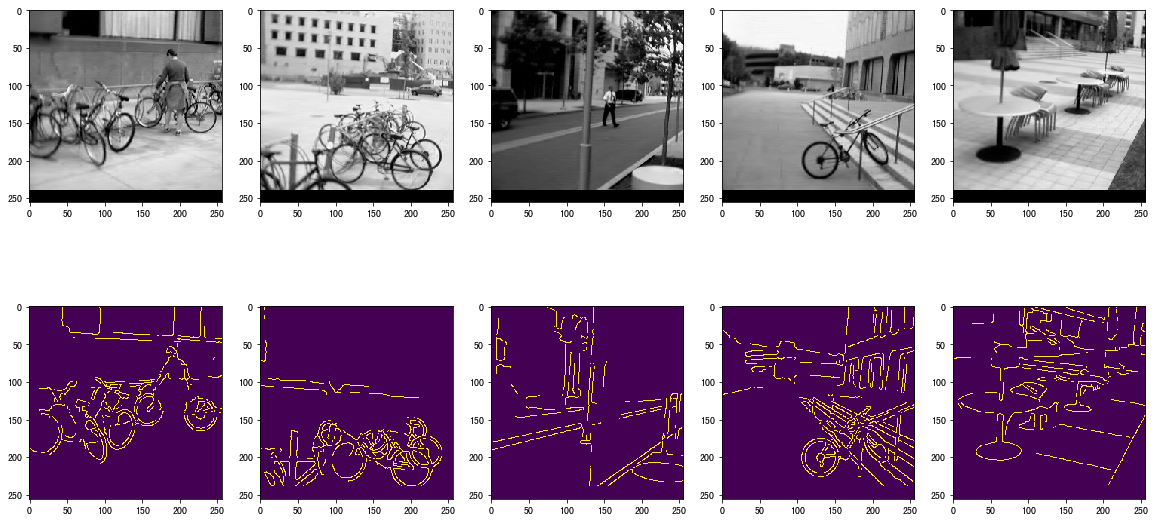

In [8]:
import matplotlib.pyplot as plt

figures,axes = plt.subplots(nrows=2,ncols=5,figsize=(20,10))

idx = np.random.permutation(np.size(xs,0))

for i in range(5):
    axes[0,i].imshow(xs[i],cmap='gray',vmin=0,vmax=1)
    axes[1,i].imshow(ys[i])
    
plt.show()

# 数据模型

In [9]:
from torchvision import transforms, utils
import torch.utils.data
from PIL import Image
import random
from skimage.util import random_noise

class CustomDataset(torch.utils.data.Dataset):#需要继承data.Dataset
    def __init__(self,xs,ys,istrain=True,itype='gray'):
        
        assert len(xs)==len(ys)
        
        self.itype = itype
        
        self.xs = xs;
        self.ys = ys
        self.istrain = istrain
        
    def __getitem__(self, index):
        x = self.xs[index]
        y = self.ys[index]
        
        if self.istrain:
            dx,dy = random.randint(0,10),random.randint(0,10)
            
            h,w = y.shape
            
            #x = random_noise(x,var = random.random()*0.005)
            
            xt = np.zeros_like(x)
            yt = np.zeros_like(y)
            
            if self.itype=='rgb' or self.itype=='hsv':
                xt[:h-dx,:w-dy,:] = x[dx:,dy:,:]
            else:
                xt[:h-dx,:w-dy] = x[dx:,dy:]
            
            yt[:h-dx,:w-dy] = y[dx:,dy:]
            
            x,y = xt,yt
        
        if self.itype=='rgb':
            x = Image.fromarray(np.uint8(x*255),'RGB')
        elif self.itype=='hsv':
            x = Image.fromarray(np.uint8(x*255),'HSV')
        else:
            x = Image.fromarray(np.uint8(x*255),'L')
            
        if self.istrain:

            transformx = transforms.Compose([
                transforms.ColorJitter(brightness =0.5, contrast=0.5),
                transforms.ToTensor()
            ])


            x = transformx(x)
        else:
            transformx = transforms.Compose([
                transforms.ToTensor()
            ])

            x = transformx(x)

        y = torch.tensor(y,dtype=torch.float32)
        
        return x,y
    
    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return len(self.xs)

In [10]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Hyper parameters
num_epochs = 20
batch_size = 1

state = {'max_stop':4,
         'min_epoch':100,
         'best_score':100,
         'save_path':f'{model_path}{model_name}.mdl'}

rid = np.random.permutation(len(xs))
xs,ys = xs[rid],ys[rid]

num_val = int(len(xs))

train_dataset,eval_dataset = CustomDataset(xs,ys,itype='gray'),CustomDataset(xs[:num_val],ys[:num_val],False,itype='gray')


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)



In [11]:
x,y = eval_dataset[0]
len(train_dataset),len(eval_dataset),torch.max(x),torch.max(y)

(1317, 1317, tensor(0.8745), tensor(1.))

# 测试图片增强

tensor(0.0118) tensor(0.8784) torch.Size([1, 256, 256])
tensor(0.1451) tensor(0.7294) torch.Size([1, 256, 256])
tensor(0.0471) tensor(0.9843) torch.Size([1, 256, 256])
tensor(0.) tensor(1.) torch.Size([1, 256, 256])


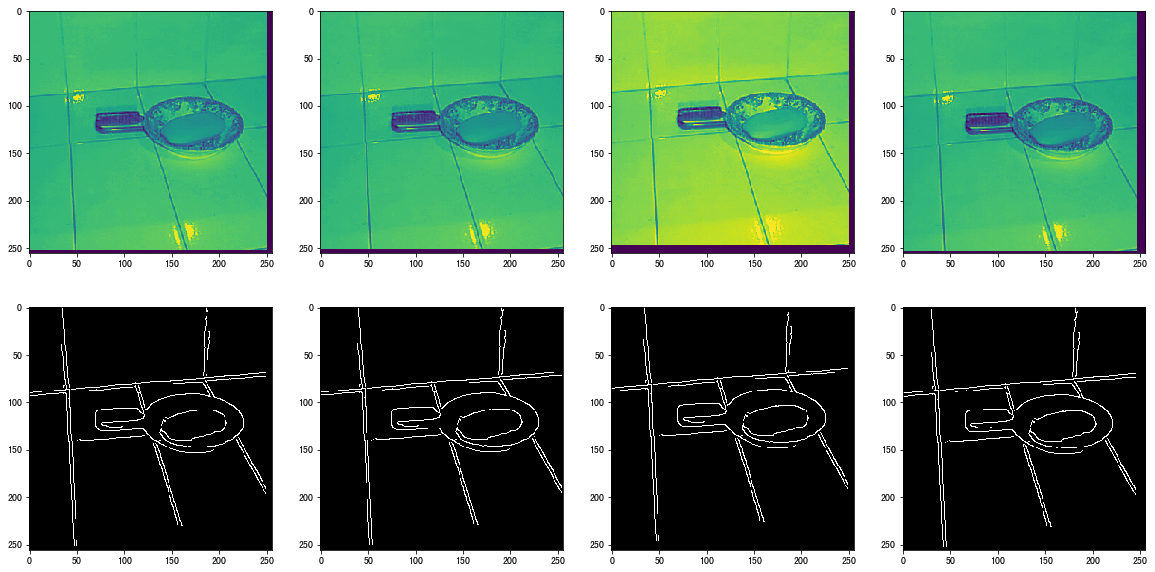

In [12]:
from skimage.color import hsv2rgb
_,axes=plt.subplots(nrows=2,ncols=4,figsize=(20,10))
for i in range(4):
    x,y = train_dataset[1]
    
    print(torch.min(x),torch.max(x),x.shape)
    
    axes[0,i].imshow(x[0,:,:])
    axes[1,i].imshow(y[:,:],cmap='gray')
    
plt.show()

tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


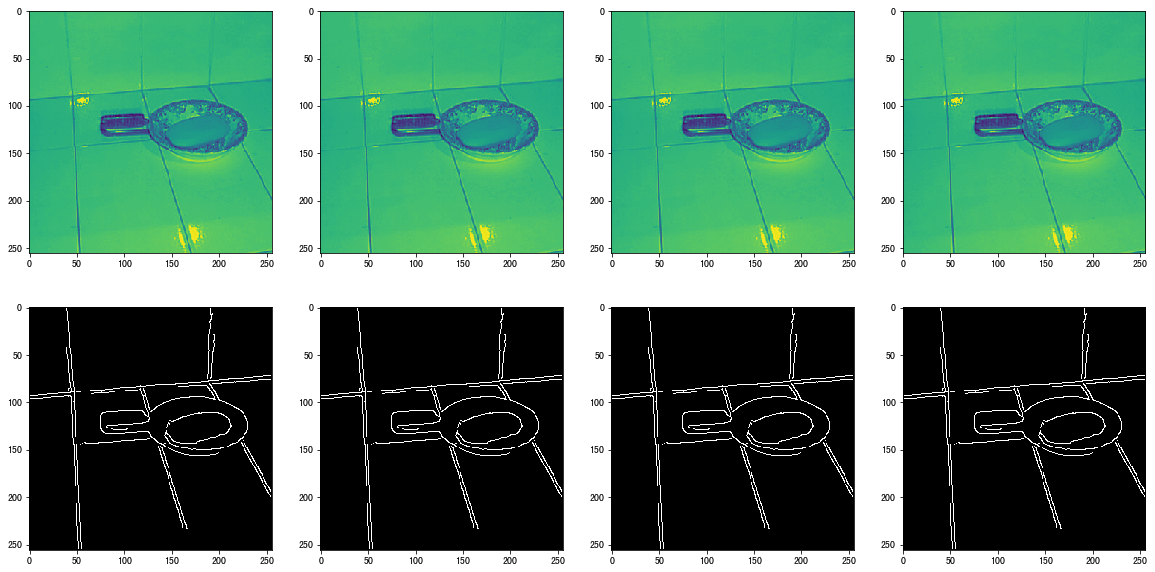

In [13]:
_,axes=plt.subplots(nrows=2,ncols=4,figsize=(20,10))
for i in range(4):
    x,y = eval_dataset[1]
    
    print(torch.min(x),torch.max(x))
    
    axes[0,i].imshow(x[0,:,:])
    axes[1,i].imshow(y[:,:],cmap='gray')
    
plt.show()

# 训练

In [14]:
model = RestoreNet(channel=1).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()

In [15]:
#%%script false
import time
t1 = time.time()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
losses = train(model,train_loader,eval_loader,criterion,optimizer,500,device,state)

t2 = time.time()

Epoch [1/500], Step [4/1317], Loss: 0.74077/0.57469 
Epoch [2/500], Step [4/1317], Loss: 0.50870/0.47647 
Epoch [3/500], Step [4/1317], Loss: 0.45210/0.44939 
Epoch [4/500], Step [4/1317], Loss: 0.42105/0.40064 
Epoch [5/500], Step [4/1317], Loss: 0.39871/0.38681 
Epoch [6/500], Step [4/1317], Loss: 0.38172/0.37128 
Epoch [7/500], Step [4/1317], Loss: 0.36884/0.35176 
Epoch [8/500], Step [4/1317], Loss: 0.36223/0.35090 
Epoch [9/500], Step [4/1317], Loss: 0.34758/0.33387 
Epoch [10/500], Step [4/1317], Loss: 0.33675/0.31805 
Epoch [11/500], Step [4/1317], Loss: 0.32814/0.32029 
Epoch [12/500], Step [4/1317], Loss: 0.31947/0.30933 
Epoch [13/500], Step [4/1317], Loss: 0.31153/0.29679 
Epoch [14/500], Step [4/1317], Loss: 0.30219/0.28259 
Epoch [15/500], Step [4/1317], Loss: 0.29615/0.27932 
Epoch [16/500], Step [4/1317], Loss: 0.29001/0.27122 
Epoch [17/500], Step [4/1317], Loss: 0.28304/0.26601 
Epoch [18/500], Step [4/1317], Loss: 0.27756/0.26412 
Epoch [19/500], Step [4/1317], Loss: 

Epoch [152/500], Step [4/1317], Loss: 0.12267/0.11167 
Epoch [153/500], Step [4/1317], Loss: 0.12221/0.11329 
Epoch [154/500], Step [4/1317], Loss: 0.12186/0.11245 
Epoch [155/500], Step [4/1317], Loss: 0.12164/0.11227 
Epoch [156/500], Step [4/1317], Loss: 0.12087/0.11173 
Epoch [157/500], Step [4/1317], Loss: 0.12465/0.11145 
Epoch [158/500], Step [4/1317], Loss: 0.12118/0.11103 
Epoch [159/500], Step [4/1317], Loss: 0.12030/0.11165 
Epoch [160/500], Step [4/1317], Loss: 0.12280/0.11233 
Epoch [161/500], Step [4/1317], Loss: 0.11971/0.11152 
Epoch [162/500], Step [4/1317], Loss: 0.12029/0.11096 
Epoch [163/500], Step [4/1317], Loss: 0.12116/0.11190 
Epoch [164/500], Step [4/1317], Loss: 0.11988/0.11075 
Epoch [165/500], Step [4/1317], Loss: 0.11914/0.11008 
Epoch [166/500], Step [4/1317], Loss: 0.12019/0.11148 
Epoch [167/500], Step [4/1317], Loss: 0.11772/0.11059 
Epoch [168/500], Step [4/1317], Loss: 0.12058/0.11058 
Epoch [169/500], Step [4/1317], Loss: 0.11883/0.10944 
Epoch [170

In [16]:
print(f'Total time:{(t2-t1)/60}')
print(len(losses))
print(losses[-1][0],losses[-1][1])

Total time:431.7791967749596
255
0.10786192455585698 0.09958115537794436


In [17]:
model.load_state_dict(torch.load(state['save_path'])['state_dict'])
print(torch.load(state['save_path'])['state'])

{'max_stop': 4, 'min_epoch': 100, 'best_score': 0.09827915899987327, 'save_path': '/home/liucc/Workspace/02_Ellipse/06_model/ellipse_general.mdl'}


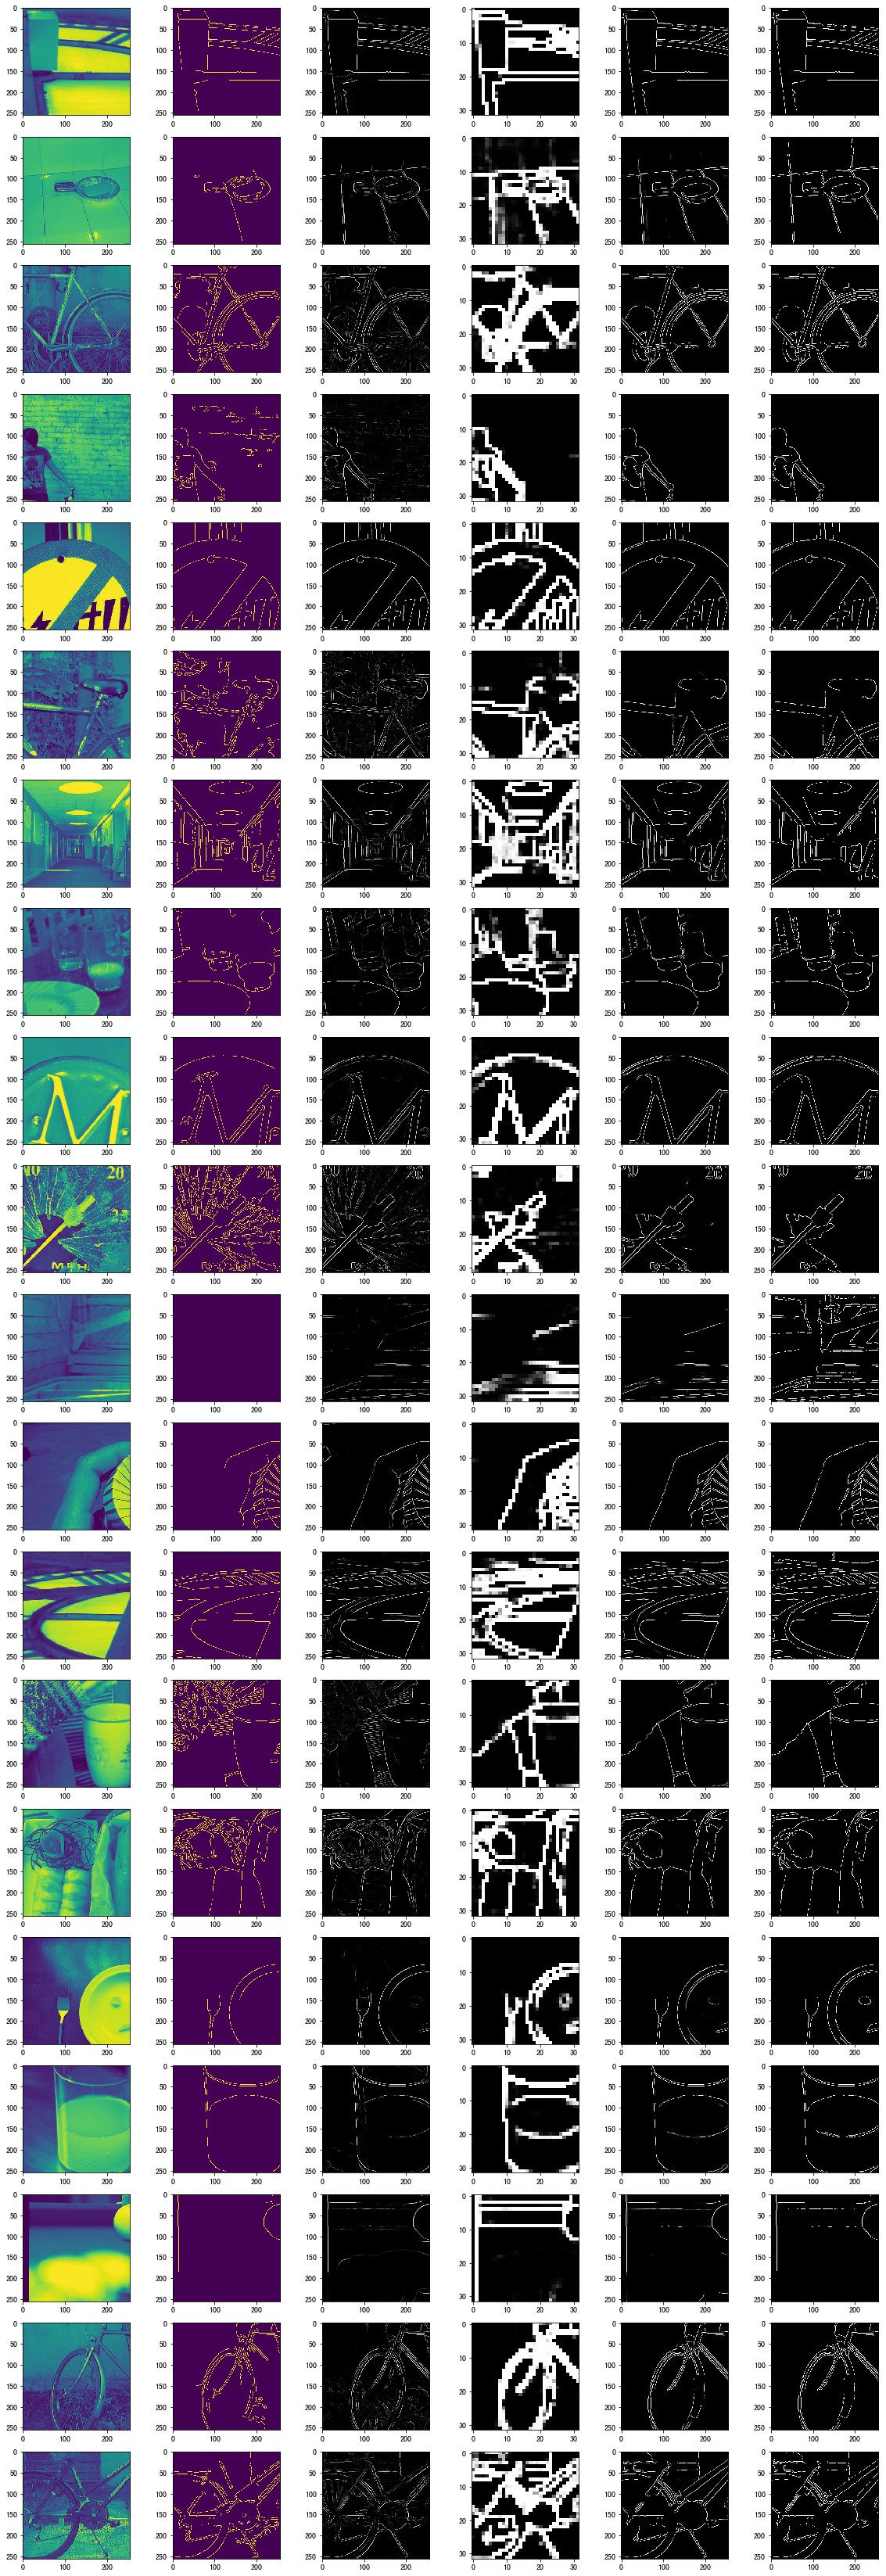

In [18]:
#%%script false
from skimage.util import random_noise
from skimage.feature import canny

t_og,t_gt,t_pr = test(model,eval_loader,device)
_,axes = plt.subplots(ncols=6,nrows=20,figsize=(20,60))

pz = 0


for i in range(20):
    imc = canny(t_og[pz+i,0,:,:],sigma=1.5,low_threshold=0.1,high_threshold=0.5)
    axes[i,0].imshow(t_og[pz+i,0,:,:])
    axes[i,1].imshow(imc)
    
    axes[i,2].imshow(t_pr[0][pz+i,0,:,:],cmap=plt.cm.gray, vmin=0, vmax=1)
    axes[i,3].imshow(t_pr[4][pz+i,0,:,:],cmap=plt.cm.gray, vmin=0, vmax=1)
    axes[i,4].imshow(t_pr[7][pz+i,0,:,:],cmap=plt.cm.gray, vmin=0, vmax=1)
    #axes[i,5].imshow(t_pr[3][i,0,:,:],cmap=plt.cm.gray, vmin=0, vmax=1)
    
    axes[i,5].imshow(t_gt[pz+i,:,:],cmap=plt.cm.gray, vmin=0, vmax=1)
    
plt.show()


# 预测

In [19]:
path = r'/home/liucc/Workspace/02_Ellipse/03_results/02_prasad/01_raw'


In [20]:
import sys
sys.path.append('/home/liucc/Workspace/02_Ellipse/01_data')
from cc_process_image import *

In [21]:
import os

names = os.listdir(f'{path}')
names = [n.split('.')[0] for n in names if n[-3:]=='jpg']
names.sort()
print(names[:10])

imxs = get_all_images(f'{path}',names,'jpg',itype='gray')

imxs = preprocess_images(imxs,scale=True)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010']


/home/liucc/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/liucc/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


In [22]:
from cnn_model import *
imos = []
for im in imxs:

    imo = predict(model,im,device)
    
    imos.append(imo)

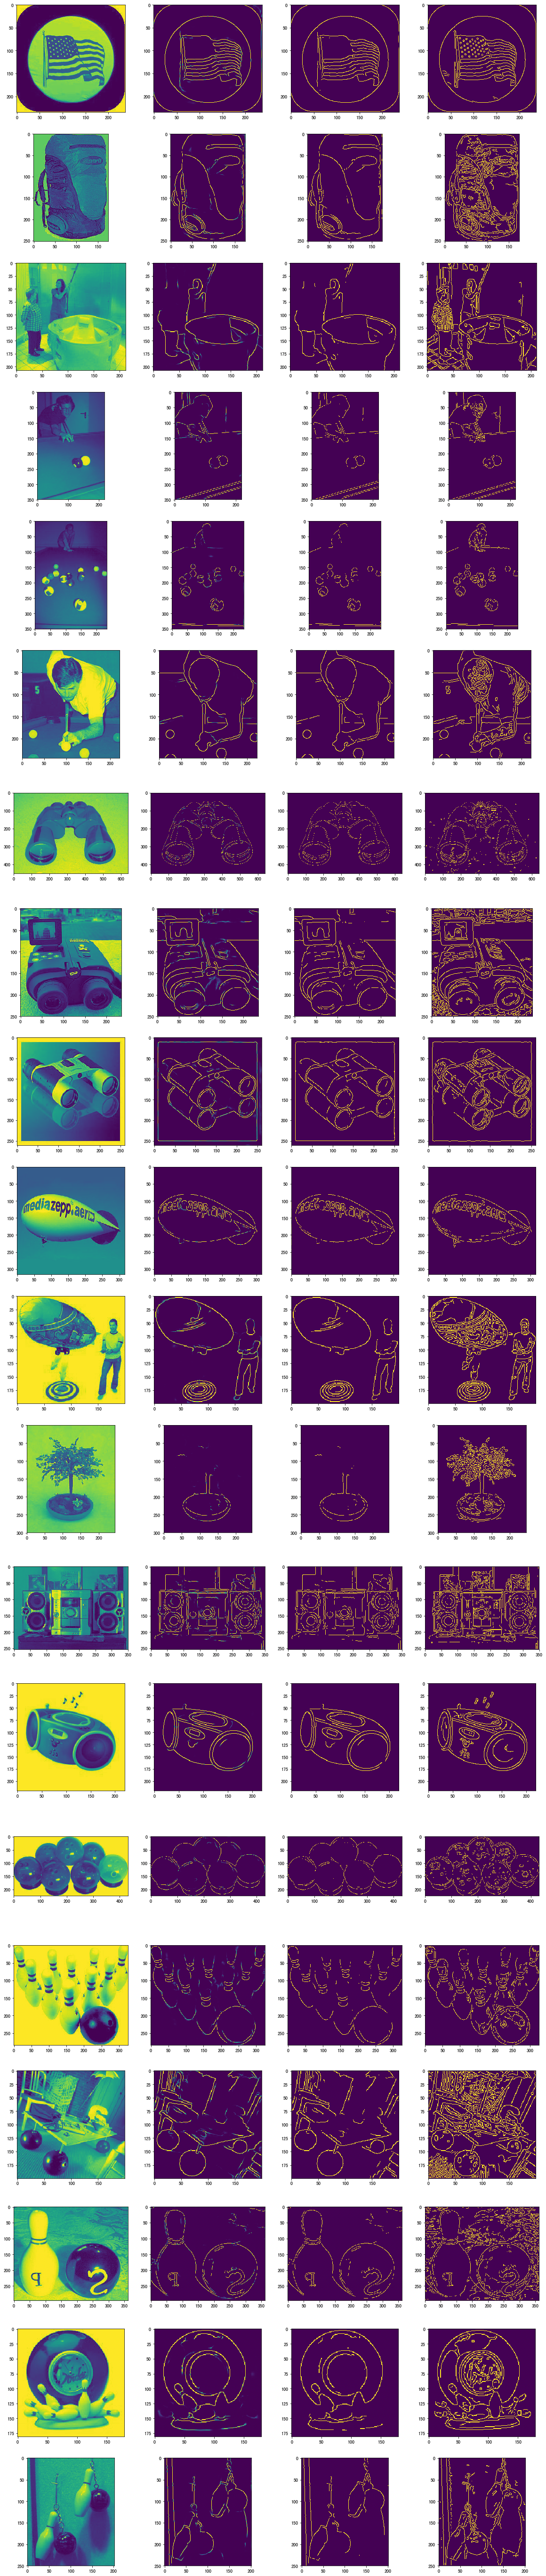

In [23]:
import imageio
from skimage.morphology import skeletonize_3d
from skimage.feature import canny
from skimage.color import rgb2gray

num = 20

_,axes = plt.subplots(nrows=num,ncols=4,figsize=(20,5*num))

for i,(im_x,im_z) in enumerate(zip(imxs[:num],imos[:num])):
    axes[i,0].imshow(im_x)
    
    axes[i,1].imshow(im_z)
    
    axes[i,2].imshow(postprocess_image(im_z,thr=0.5))
    axes[i,3].imshow(canny(rgb2gray(im_x)))
    
    
plt.show()